# This notebook is made to only include events that pass the appropriate cuts

From the DSTs:
- 0 < DT < 1500
- S2e > 3k (to not lose x-rays, *CHECK THIS!!!*)
- Recalculate the nS1s and nS2s
- 1 S1 + 1 S2


Then from the hits (I think?):
- Z < 1370mm
- $\Delta Z$ < 150 mm

$\Delta Z$ is defined as the total range in Z of the track

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

import functions_HE as func

%load_ext autoreload
%autoreload 2

In [4]:
RUN_NUMBER = 15107
TIMESTAMP  = 140425

In [7]:
# Load in DSTs,
# whole thing
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/sophronia/trigger2/'

hdst = []

for i in tqdm(range(1,8)):
    print(f"LDC {i}")
    folder_path = n100_dir + 'ldc' + str(i) + '/'
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    for file in tqdm(file_names):
        try:
            hdst.append(load_dst(folder_path + file, 'DST', 'Events'))
        except Exception as e:
            print(f'File {file} broke with error:\n{e}')        

hdst = pd.concat(hdst)

  0%|          | 0/7 [00:00<?, ?it/s]

LDC 1


 14%|█▍        | 1/7 [01:29<08:58, 89.80s/it]

LDC 2


 29%|██▊       | 2/7 [03:26<08:47, 105.59s/it]

LDC 3


 43%|████▎     | 3/7 [05:22<07:20, 110.17s/it]

LDC 4


 57%|█████▋    | 4/7 [07:12<05:31, 110.47s/it]

LDC 5


 71%|███████▏  | 5/7 [09:13<03:47, 113.96s/it]

LDC 6


 86%|████████▌ | 6/7 [11:13<01:56, 116.03s/it]

LDC 7


100%|██████████| 7/7 [13:17<00:00, 113.90s/it]


In [8]:
display(hdst)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,156,1.742935e+09,0,0,1,2,600.0,24.381660,136.866943,619825.0,...,2111,-218.339066,-218.339066,19.622758,137.029985,27.834735,139.828428,0.200402,240.724924,195.344402
1,156,1.742935e+09,0,1,1,2,600.0,24.381660,136.866943,619825.0,...,2152,787.668030,787.668030,18.626027,116.011572,-55.936634,128.792826,-0.449277,221.975949,200.956738
2,275,1.742935e+09,0,0,1,1,375.0,20.105528,130.680893,1217525.0,...,2539,185.960632,185.960632,18.371055,15.761644,-65.178615,67.057299,-1.333529,190.955556,208.454665
3,317,1.742935e+09,0,0,3,3,225.0,19.746523,148.996826,562650.0,...,776,-3.149063,-3.149063,3.503168,66.337331,2.219122,66.374438,0.033440,211.118392,194.975194
4,317,1.742935e+09,0,1,3,3,225.0,19.746523,148.996826,562650.0,...,724,452.851776,452.851776,6.683204,17.697822,39.607853,43.381966,1.150585,253.569501,263.959456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,391495,1.742940e+09,65535,5,0,6,NaN,NaN,NaN,NaN,...,856,NaN,NaN,3.964980,-80.113536,134.404147,156.469337,2.108317,242.908390,271.176978
9,391810,1.742940e+09,0,0,1,4,725.0,35.936073,198.177307,754925.0,...,381,569.543152,569.543152,4.456573,-47.094804,33.190097,57.615129,2.527685,233.144656,219.503977
10,391810,1.742940e+09,0,1,1,4,725.0,35.936073,198.177307,754925.0,...,2237,647.567139,647.567139,8.598272,16.955107,33.760311,37.778754,1.105374,243.084097,206.085915
11,391810,1.742940e+09,0,2,1,4,725.0,35.936073,198.177307,754925.0,...,1914,865.564148,865.564148,8.254498,-112.437175,60.467513,127.665338,2.648173,249.455369,211.893678


### DT removal

In [11]:
low_DT = hdst[hdst.DT < 1500]
low_DT = low_DT[low_DT.DT > 0]

print(f'Efficiency:')
print(f'{100*(len(low_DT.event.unique())/len(hdst.event.unique())):.2f}%')

Efficiency:
90.79%


### Low s2e removal

Text(0.5, 0, 's2e')

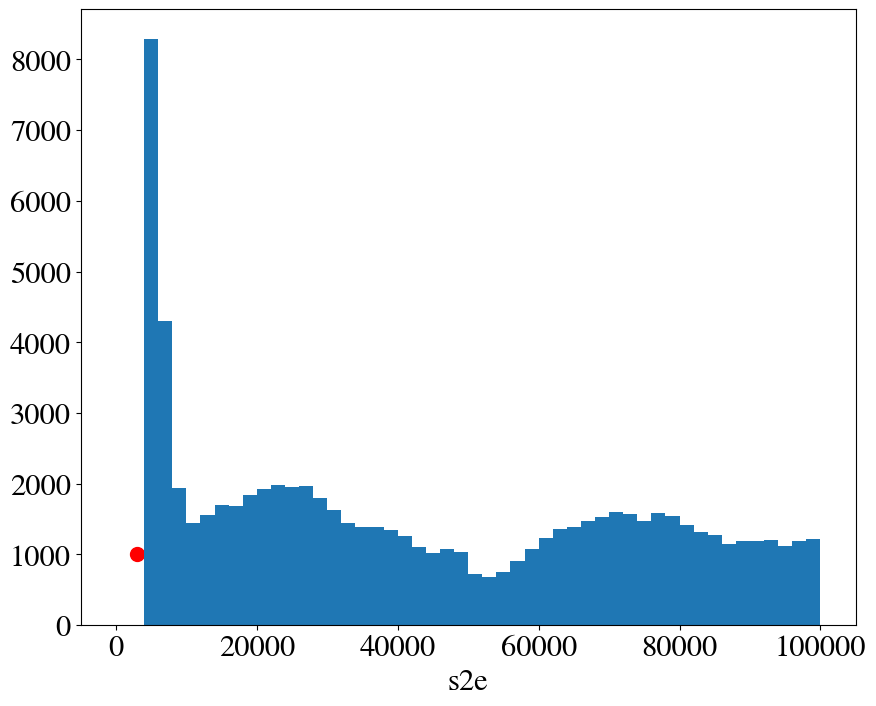

In [20]:
plt.hist(low_DT.S2e.values, bins = 50, range = (0, 100000))
plt.scatter(3000, 1000, s = 100, c = 'red')
plt.xlabel('s2e')


In [21]:
# need to check this
high_s2e = low_DT[low_DT.S2e > 10000]

print(f'Relative Efficiency:')
print(f'{100*(len(high_s2e.event.unique())/len(low_DT.event.unique())):.2f}%')

print(f'Absolute Efficiency:')
print(f'{100*(len(high_s2e.event.unique())/len(hdst.event.unique())):.2f}%')

Relative Efficiency:
100.00%
Absolute Efficiency:
90.79%
